# Homework 5
*This notebook includes both coding and written questions. Please hand in this notebook file with all the outputs and your answers to the written questions.*

This assignment covers K-Means and HAC methods for clustering.

In [1]:
# Setup
from time import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from skimage import io

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Introduction
In this assignment, you will use clustering algorithms to segment images. You will then use these segmentations to identify foreground and background objects.

Your assignment will involve the following subtasks:
- **Clustering algorithms**: Implement K-Means clustering and Hierarchical Agglomerative Clustering.
- **Pixel-level features**: Implement a feature vector that combines color and position information and implement feature normalization.
- **Quantitative Evaluation**: Evaluate segmentation algorithms with a variety of parameter settings by comparing your computed segmentations against a dataset of ground-truth segmentations.

## 1 Clustering Algorithms (40 points)

### 1.1 K-Means Clustering (20 points)
As discussed in class, K-Means is one of the most popular clustering algorithms. We have provided skeleton code for K-Means clustering in the file `segmentation.py`. Your first task is to finish implementing **`kmeans`** in `segmentation.py`. This version uses nested for loops to assign points to the closest centroid and compute new mean of each cluster.

In [2]:
import numpy as np
import random
from scipy.spatial.distance import squareform, pdist
from skimage.util import img_as_float

In [3]:
def kmeans(features, k, num_iters=100):
    """ Use kmeans algorithm to group features into k clusters.
    K-Means algorithm can be broken down into following steps:
        1. Randomly initialize cluster centers
        2. Assign each point to the closest center
        3. Compute new center of each cluster
        4. Stop if cluster assignments did not change
        5. Go to step 2
    Args:
        features - Array of N features vectors. Each row represents a feature
            vector.
        k - Number of clusters to form.
        num_iters - Maximum number of iterations the algorithm will run.
    Returns:
        assignments - Array representing cluster assignment of each point.
            (e.g. i-th point is assigned to cluster assignments[i])
    """

    N, D = features.shape

    assert N >= k, 'Number of clusters cannot be greater than number of points'

    # Randomly initalize cluster centers
    idxs = np.random.choice(N, size=k, replace=False)
    centers = features[idxs]
    assignments = np.zeros(N)

    for n in range(num_iters):
        ### YOUR CODE HERE
        assignments_new = np.zeros_like(assignments)
        for i in range(N):
            p = features[i]
            d = []
            for j in range(k):
                c = centers[j]
                d.append(np.linalg.norm(p - c))
            assignments_new[i] = np.argmin(d)

        if np.sum(assignments == assignments_new) == 0:
            return assignments 
        else:
            assignments = assignments_new
            for i in range(k):
                centers[i] = np.mean(features[assignments_new == i], axis=0)
        ### END YOUR CODE

    return assignments


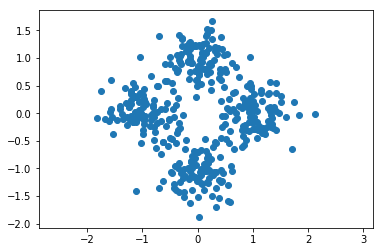

In [4]:
# Generate random data points for clustering

# Cluster 1
mean1 = [-1, 0]
cov1 = [[0.1, 0], [0, 0.1]]
X1 = np.random.multivariate_normal(mean1, cov1, 100)

# Cluster 2
mean2 = [0, 1]
cov2 = [[0.1, 0], [0, 0.1]]
X2 = np.random.multivariate_normal(mean2, cov2, 100)

# Cluster 3
mean3 = [1, 0]
cov3 = [[0.1, 0], [0, 0.1]]
X3 = np.random.multivariate_normal(mean3, cov3, 100)

# Cluster 4
mean4 = [0, -1]
cov4 = [[0.1, 0], [0, 0.1]]
X4 = np.random.multivariate_normal(mean4, cov4, 100)

# Merge two sets of data points
X = np.concatenate((X1, X2, X3, X4))

# Plot data points
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal')
plt.show()

kmeans running time: 0.773104 seconds.


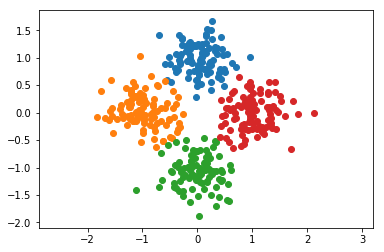

In [6]:
np.random.seed(0)
start = time()
assignments = kmeans(X, 4)
end = time()
# print(assignments)
kmeans_runtime = end - start

print("kmeans running time: %f seconds." % kmeans_runtime)

for i in range(4):
    cluster_i = X[assignments==i]
    plt.scatter(cluster_i[:, 0], cluster_i[:, 1])

plt.axis('equal')
plt.show()

We can use numpy functions and broadcasting to make kmeans faster. Implement **`kmeans_fast`** in `segmentation.py`. This should run at least 10 times faster than the previous implementation.

In [7]:
X.shape

(400, 2)

In [8]:
def kmeans_fast(features, k, num_iters=100):
    """ Use kmeans algorithm to group features into k clusters.
    This function makes use of numpy functions and broadcasting to speed up the
    first part(cluster assignment) of kmeans algorithm.
    Hints
    - You may find np.repeat and np.argmin useful
    Args:
        features - Array of N features vectors. Each row represents a feature
            vector.
        k - Number of clusters to form.
        num_iters - Maximum number of iterations the algorithm will run.
    Returns:
        assignments - Array representing cluster assignment of each point.
            (e.g. i-th point is assigned to cluster assignments[i])
    """

    N, D = features.shape

    assert N >= k, 'Number of clusters cannot be greater than number of points'

    # Randomly initalize cluster centers
    idxs = np.random.choice(N, size=k, replace=False)
    centers = features[idxs]
    assignments = np.zeros(N)

    for n in range(num_iters):
        ### YOUR CODE HERE
        d = []
        for i in range(k):
            d.append(np.linalg.norm(features - centers[i], axis=-1))

        d_merge = np.array(d).T
        # print(d_merge.shape)
        assignments_new = np.argmin(d_merge, axis=-1)
        
        if np.sum(assignments == assignments_new) == 0:
            return assignments 
        else:
            assignments = assignments_new
            for i in range(k):
                centers[i] = np.mean(features[assignments_new == i], axis=0)
        ### END YOUR CODE

    return assignments



kmeans running time: 0.024471 seconds.
31.592621 times faster!


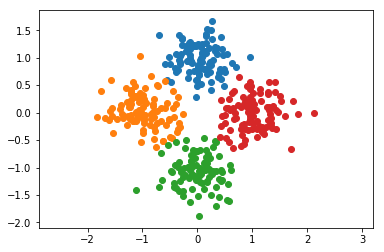

In [9]:
np.random.seed(0)
start = time()
assignments = kmeans_fast(X, 4)
end = time()
# print(assignments)
kmeans_fast_runtime = end - start
print("kmeans running time: %f seconds." % kmeans_fast_runtime)
print("%f times faster!" % (kmeans_runtime / kmeans_fast_runtime))

for i in range(4):
    cluster_i = X[assignments==i]
    plt.scatter(cluster_i[:, 0], cluster_i[:, 1])

plt.axis('equal')
plt.show()

### 1.2 Hierarchical Agglomerative Clustering (20 points)
Another simple clustering algorithm is Hieararchical Agglomerative Clustering, which is somtimes abbreviated as HAC. In this algorithm, each point is initially assigned to its own cluster. Then cluster pairs are merged until we are left with the desired number of predetermined clusters (see Algorithm 1).

Implement **`hiererachical_clustering`** in `segmentation.py`.

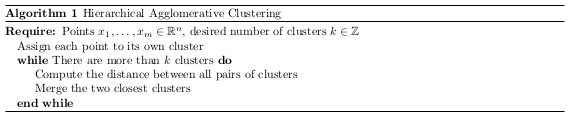

In [11]:
X.shape

(400, 2)

In [12]:
X[:, 1:2].shape

(400, 1)

In [13]:
def hierarchical_clustering(features, k):
    """ Run the hierarchical agglomerative clustering algorithm.
    The algorithm is conceptually simple:
    Assign each point to its own cluster
    While the number of clusters is greater than k:
        Compute the distance between all pairs of clusters
        Merge the pair of clusters that are closest to each other
    We will use Euclidean distance to defeine distance between two clusters.
    Recomputing the centroids of all clusters and the distances between all
    pairs of centroids at each step of the loop would be very slow. Thankfully
    most of the distances and centroids remain the same in successive
    iterations of the outer loop; therefore we can speed up the computation by
    only recomputing the centroid and distances for the new merged cluster.
    Even with this trick, this algorithm will consume a lot of memory and run
    very slowly when clustering large set of points. In practice, you probably
    do not want to use this algorithm to cluster more than 10,000 points.
    Args:
        features - Array of N features vectors. Each row represents a feature
            vector.
        k - Number of clusters to form.
    Returns:
        assignments - Array representing cluster assignment of each point.
            (e.g. i-th point is assigned to cluster assignments[i])
    """


    # We track 3 matrix, e.g.
    # feature_matrix, centers_matrix, sim_matrix

    N, D = features.shape

    assert N >= k, 'Number of clusters cannot be greater than number of points'

    # Assign each point to its own cluster
    assignments = np.arange(N)
    centers = np.copy(features)
    n_clusters = N
    dis = 0.0
    for i in range(D):
        c = centers[:, i:i+1]
        dis += (c - c.T)**2
    dis = np.sqrt(dis)
    np.fill_diagonal(dis, np.Inf)
    
    while n_clusters > k:
        ### YOUR CODE HERE
        y, x = (np.unravel_index(dis.argmin(), dis.shape))
        asg_first = min(y, x)
        asg_second = max(y, x)
        assignments[assignments == asg_second] = asg_first
        assignments[assignments > asg_second] -= 1
        dis = np.delete(dis, asg_second, axis=0)
        dis = np.delete(dis, asg_second, axis=1)
        
        centers = np.delete(centers, asg_second, axis=0)
        c_new = np.mean(features[assignments == asg_first], axis=0)
        centers[asg_first] = c_new
        d = np.linalg.norm(centers - c_new, axis=-1)
        dis[asg_first] = d
        dis[:, asg_first] = d
        dis[asg_first, asg_first] = np.Inf 

        n_clusters -= 1
        ### END YOUR CODE

    return assignments



hierarchical_clustering running time: 0.114648 seconds.


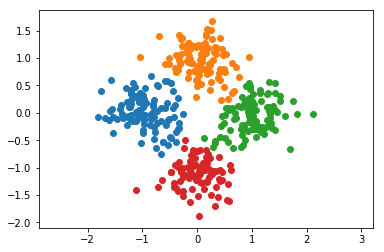

In [14]:
start = time()
assignments = hierarchical_clustering(X, 4)
end = time()
# print(X.shape)
# print(np.unique(assignments))
print("hierarchical_clustering running time: %f seconds." % (end - start))

for i in range(4):
    cluster_i = X[assignments==i]
    plt.scatter(cluster_i[:, 0], cluster_i[:, 1])

plt.axis('equal')
plt.show()

## 2 Pixel-Level Features (30 points)
Before we can use a clustering algorithm to segment an image, we must compute some *feature vectore* for each pixel. The feature vector for each pixel should encode the qualities that we care about in a good segmentation. More concretely, for a pair of pixels $p_i$ and $p_j$ with corresponding feature vectors $f_i$ and $f_j$, the distance between $f_i$ and $f_j$ should be small if we believe that $p_i$ and $p_j$ should be placed in the same segment and large otherwise.

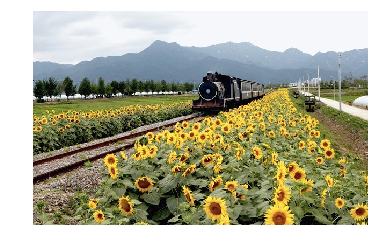

In [15]:
# Load and display image
img = io.imread('data/train.jpg')
H, W, C = img.shape

plt.imshow(img)
plt.axis('off')
plt.show()

### 2.1 Color Features (15 points)
One of the simplest possible feature vectors for a pixel is simply the vector of colors for that pixel. Implement **`color_features`** in `segmentation.py`. Output should look like the following:
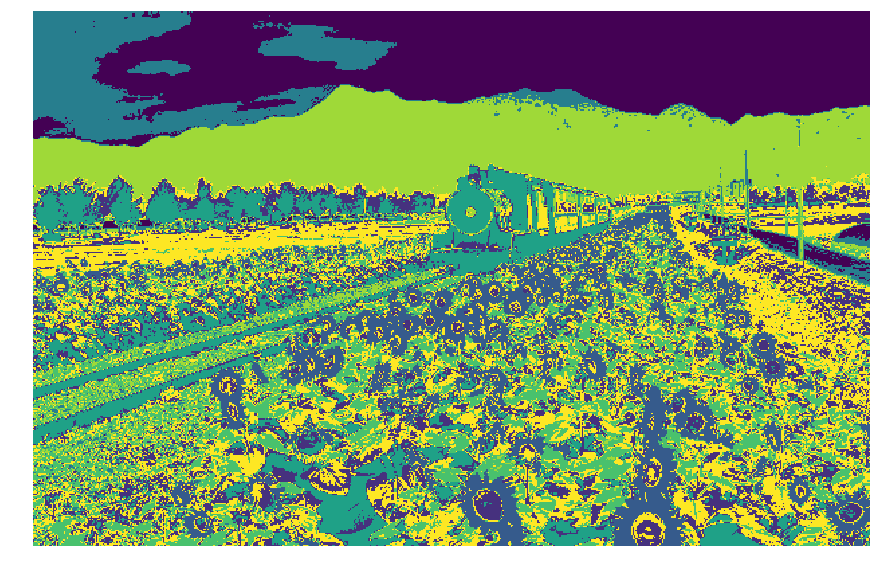

In [16]:
### Pixel-Level Features
def color_features(img):
    """ Represents a pixel by its color.
    Args:
        img - array of shape (H, W, C)
    Returns:
        features - array of (H * W, C)
    """
    H, W, C = img.shape
    img = img_as_float(img)
    features = np.zeros((H*W, C))

    ### YOUR CODE HERE
    features = img.reshape(H*W, C)
    ### END YOUR CODE

    return features


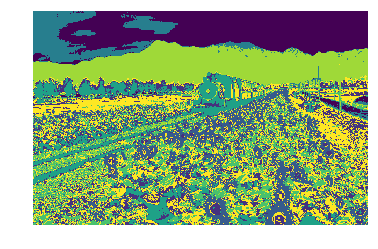

In [17]:

np.random.seed(0)

features = color_features(img)

# Sanity checks
assert features.shape == (H * W, C),\
    "Incorrect shape! Check your implementation."

assert features.dtype == np.float,\
    "dtype of color_features should be float."

assignments = kmeans_fast(features, 8)
segments = assignments.reshape((H, W))

# Display segmentation
plt.imshow(segments, cmap='viridis')
plt.axis('off')
plt.show()

In the cell below, we visualize each segment as the mean color of pixels in the segment.

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.util import img_as_float
from skimage import transform
from skimage import io



import os

def visualize_mean_color_image(img, segments):

    img = img_as_float(img)
    k = np.max(segments) + 1
    mean_color_img = np.zeros(img.shape)

    for i in range(k):
        mean_color = np.mean(img[segments == i], axis=0)
        mean_color_img[segments == i] = mean_color

    plt.imshow(mean_color_img)
    plt.axis('off')
    plt.show()

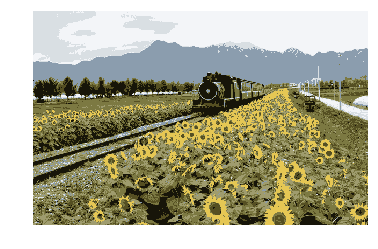

In [22]:
visualize_mean_color_image(img, segments)

### 2.2 Color and Position Features (15 points)
Another simple feature vector for a pixel is to concatenate its color and position within the image. In other words, for a pixel of color $(r, g, b)$ located at position $(x, y)$ in the image, its feature vector would be $(r, g, b, x, y)$. However, the color and position features may have drastically different ranges; for example each color channel of an image may be in the range $[0, 1)$, while the position of each pixel may have a much wider range. Uneven scaling between different features in the feature vector may cause clustering algorithms to behave poorly.

One way to correct for uneven scaling between different features is to apply some sort of normalization to the feature vector. One of the simplest types of normalization is to force each feature to have zero mean and unit variance.

Implement **`color_position_features`** in `segmentation.py`.

Output segmentation should look like the following:
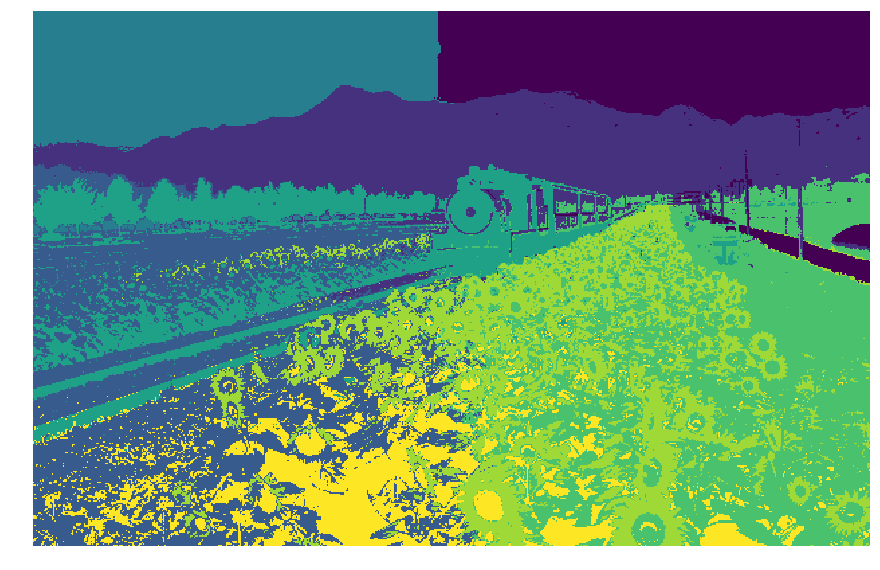

In [23]:
def color_position_features(img):
    """ Represents a pixel by its color and position.
    Combine pixel's RGB value and xy coordinates into a feature vector.
    i.e. for a pixel of color (r, g, b) located at position (x, y) in the
    image. its feature vector would be (r, g, b, x, y).
    Don't forget to normalize features.
    Hints
    - You may find np.mgrid and np.dstack useful
    - You may use np.mean and np.std
    Args:
        img - array of shape (H, W, C)
    Returns:
        features - array of (H * W, C+2)
    """
    H, W, C = img.shape
    color = img_as_float(img)
    features = np.zeros((H*W, C+2))

    ### YOUR CODE HERE
    c_feats = color_features(img)
    x, y = np.meshgrid(np.arange(W), np.arange(H))
    coord_feats = np.c_[x.ravel(), y.ravel()]
    features = np.concatenate([c_feats, coord_feats], axis=-1)
    stdev = np.std(features, axis=0, keepdims=True)
    avg = np.mean(features, axis=0, keepdims=True)
    features = (features - avg) / stdev
    ### END YOUR CODE

    return features

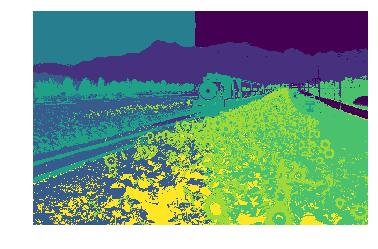

In [24]:
# from segmentation import color_position_features
np.random.seed(0)

features = color_position_features(img)

# Sanity checks
assert features.shape == (H * W, C + 2),\
    "Incorrect shape! Check your implementation."

assert features.dtype == np.float,\
    "dtype of color_features should be float."

assignments = kmeans_fast(features, 8)
segments = assignments.reshape((H, W))

# Display segmentation
plt.imshow(segments, cmap='viridis')
plt.axis('off')
plt.show()

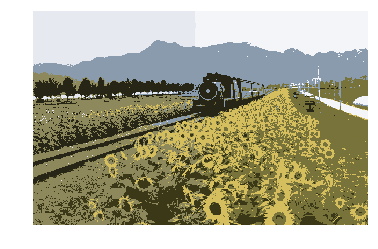

In [25]:
visualize_mean_color_image(img, segments)

### Extra Credit: Implement Your Own Feature
For this programming assignment we have asked you to implement a very simple feature transform for each pixel. While it is not required, you should feel free to experiment with other feature transforms. Could your final segmentations be improved by adding gradients, edges, SIFT descriptors, or other information to your feature vectors? Could a different type of normalization give better results?

Implement your feature extractor **`my_features`** in `segmentation.py`

Depending on the creativity of your approach and the quality of your writeup, implementing extra feature vectors can be worth extra credit (up to 5% of total points).

In [26]:
def my_features(img):
    """ Implement your own features
    Args:
        img - array of shape (H, W, C)
    Returns:
        features - array of (H * W, C)
    """
    features = None
    ### YOUR CODE HERE
    pass
    ### END YOUR CODE
    return features
    

**Describe your approach**: (YOUR APPROACH)

In [ ]:
# from segmentation import my_features

# Feel free to experiment with different images
# and varying number of segments
img = io.imread('data/train.jpg')
num_segments = 8

H, W, C = img.shape

# Extract pixel-level features
features = my_features(img)

# Run clustering algorithm
assignments = kmeans_fast(features, num_segments)

segments = assignments.reshape((H, W))

# Display segmentation
plt.imshow(segments, cmap='viridis')
plt.axis('off')
plt.show()

## 3 Quantitative Evaluation (30 points)

Looking at images is a good way to get an idea for how well an algorithm is working, but the best way to evaluate an algorithm is to have some quantitative measure of its performance.

For this project we have supplied a small dataset of cat images and ground truth segmentations of these images into foreground (cats) and background (everything else). We will quantitatively evaluate different segmentation methods (features and clustering methods) on this dataset.

We can cast the segmentation task into a binary classification problem, where we need to classify each pixel in an image into either foreground (positive) or background (negative). Given the ground-truth labels, the accuracy of a segmentation is $(TP+TN)/(P+N)$.

Implement **`compute_accuracy`** in `segmentation.py`.

In [29]:
def compute_accuracy(mask_gt, mask):
    """ Compute the pixel-wise accuracy of a foreground-background segmentation
        given a ground truth segmentation.
    Args:
        mask_gt - The ground truth foreground-background segmentation. A
            logical of size H x W where mask_gt[y, x] is 1 if and only if
            pixel (y, x) of the original image was part of the foreground.
        mask - The estimated foreground-background segmentation. A logical
            array of the same size and format as mask_gt.
    Returns:
        accuracy - The fraction of pixels where mask_gt and mask agree. A
            bigger number is better, where 1.0 indicates a perfect segmentation.
    """

    accuracy = None
    ### YOUR CODE HERE
    accuracy = ((mask_gt - mask) == 0).sum() / np.prod(mask.shape, dtype=np.float64)
    ### END YOUR CODE

    return accuracy

Accuracy: 0.97


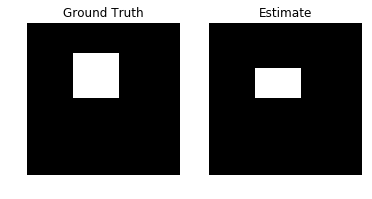

In [30]:
# from segmentation import compute_accuracy

mask_gt = np.zeros((100, 100))
mask = np.zeros((100, 100))

# Test compute_accracy function
mask_gt[20:50, 30:60] = 1
mask[30:50, 30:60] = 1

accuracy = compute_accuracy(mask_gt, mask)

print('Accuracy: %0.2f' % (accuracy))
if accuracy != 0.97:
    print('Check your implementation!')

plt.subplot(121)
plt.imshow(mask_gt)
plt.title('Ground Truth')
plt.axis('off')

plt.subplot(122)
plt.imshow(mask)
plt.title('Estimate')
plt.axis('off')

plt.show()

You can use the script below to evaluate a segmentation method’s ability to separate foreground from background on the entire provided dataset. Use this script as a starting point to evaluate a variety of segmentation parameters.

In [31]:
def compute_segmentation(img, k,
        clustering_fn=kmeans_fast,
        feature_fn=color_position_features,
        scale=0):
    """ Compute a segmentation for an image.
    First a feature vector is extracted from each pixel of an image. Next a
    clustering algorithm is applied to the set of all feature vectors. Two
    pixels are assigned to the same segment if and only if their feature
    vectors are assigned to the same cluster.
    Args:
        img - An array of shape (H, W, C) to segment.
        k - The number of segments into which the image should be split.
        clustering_fn - The method to use for clustering. The function should
            take an array of N points and an integer value k as input and
            output an array of N assignments.
        feature_fn - A function used to extract features from the image.
        scale - (OPTIONAL) parameter giving the scale to which the image
            should be in the range 0 < scale <= 1. Setting this argument to a
            smaller value will increase the speed of the clustering algorithm
            but will cause computed segments to be blockier. This setting is
            usually not necessary for kmeans clustering, but when using HAC
            clustering this parameter will probably need to be set to a value
            less than 1.
    """

    assert scale <= 1 and scale >= 0, \
        'Scale should be in the range between 0 and 1'

    H, W, C = img.shape

    if scale > 0:
        # Scale down the image for faster computation.
        img = transform.rescale(img, scale)

    features = feature_fn(img)
    assignments = clustering_fn(features, k)
    segments = assignments.reshape((img.shape[:2]))

    if scale > 0:
        # Resize segmentation back to the image's original size
        segments = transform.resize(segments, (H, W), preserve_range=True)

        # Resizing results in non-interger values of pixels.
        # Round pixel values to the closest interger
        segments = np.rint(segments).astype(int)

    return segments

In [32]:
def load_dataset(data_dir):
    """
    This function assumes 'gt' directory contains ground truth segmentation
    masks for images in 'imgs' dir. The segmentation mask for image
    'imgs/aaa.jpg' is 'gt/aaa.png'
    """

    imgs = []
    gt_masks = []

    # Load all the images under 'data_dir/imgs' and corresponding
    # segmentation masks under 'data_dir/gt'.
    for fname in sorted(os.listdir(os.path.join(data_dir, 'imgs'))):
        if fname.endswith('.jpg'):
            # Load image
            img = io.imread(os.path.join(data_dir, 'imgs', fname))
            imgs.append(img)

            # Load corresponding gt segmentation mask
            mask_fname = fname[:-4] + '.png'
            gt_mask = io.imread(os.path.join(data_dir, 'gt', mask_fname))
            gt_mask = (gt_mask != 0).astype(int) # Convert to binary mask (0s and 1s)
            gt_masks.append(gt_mask)

    return imgs, gt_masks

In [33]:
def evaluate_segmentation(mask_gt, segments):
    """ Compare the estimated segmentation with the ground truth.
    Note that 'mask_gt' is a binary mask, while 'segments' contain k segments. 
    This function compares each segment in 'segments' with the ground truth and
    outputs the accuracy of the best segment.
    Args:
        mask_gt - The ground truth foreground-background segmentation. A
            logical of size H x W where mask_gt[y, x] is 1 if and only if
            pixel (y, x) of the original image was part of the foreground.
        segments - An array of the same size as mask_gt. The value of a pixel
            indicates the segment it belongs.
    Returns:
        best_accuracy - Accuracy of the best performing segment.
            0 <= accuracy <= 1, where 1.0 indicates a perfect segmentation.
    """

    num_segments = np.max(segments) + 1
    best_accuracy = 0

    # Compare each segment in 'segments' with the ground truth
    for i in range(num_segments):
        mask = (segments == i).astype(int)
        accuracy = compute_accuracy(mask_gt, mask)
        best_accuracy = max(accuracy, best_accuracy)

    return best_accuracy

In [35]:
# from utils import load_dataset, compute_segmentation
# from segmentation import evaluate_segmentation

# Load a small segmentation dataset
imgs, gt_masks = load_dataset('./data/segmentation')

# Set the parameters for segmentation.
num_segments = 3
clustering_fn = kmeans_fast
feature_fn = color_features
scale = 0.5

mean_accuracy = 0.0

segmentations = []

for i, (img, gt_mask) in enumerate(zip(imgs, gt_masks)):
    # Compute a segmentation for this image
    segments = compute_segmentation(img, num_segments,
                                    clustering_fn=clustering_fn,
                                    feature_fn=feature_fn,
                                    scale=scale)
    
    segmentations.append(segments)
    
    # Evaluate segmentation
    accuracy = evaluate_segmentation(gt_mask, segments)
    
    print('Accuracy for image %d: %0.4f' %(i, accuracy))
    mean_accuracy += accuracy
    
mean_accuracy = mean_accuracy / len(imgs)
print('Mean accuracy: %0.4f' % mean_accuracy)

/home/sara/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Accuracy for image 0: 0.8079
Accuracy for image 1: 0.9592
Accuracy for image 2: 0.9639
Accuracy for image 3: 0.9047
Accuracy for image 4: 0.9738
Accuracy for image 5: 0.6836
Accuracy for image 6: 0.6725
Accuracy for image 7: 0.6690
Accuracy for image 8: 0.8372
Accuracy for image 9: 0.9543
Accuracy for image 10: 0.8518
Accuracy for image 11: 0.8111
Accuracy for image 12: 0.7329
Accuracy for image 13: 0.6655
Accuracy for image 14: 0.7452
Accuracy for image 15: 0.4983
Mean accuracy: 0.7957


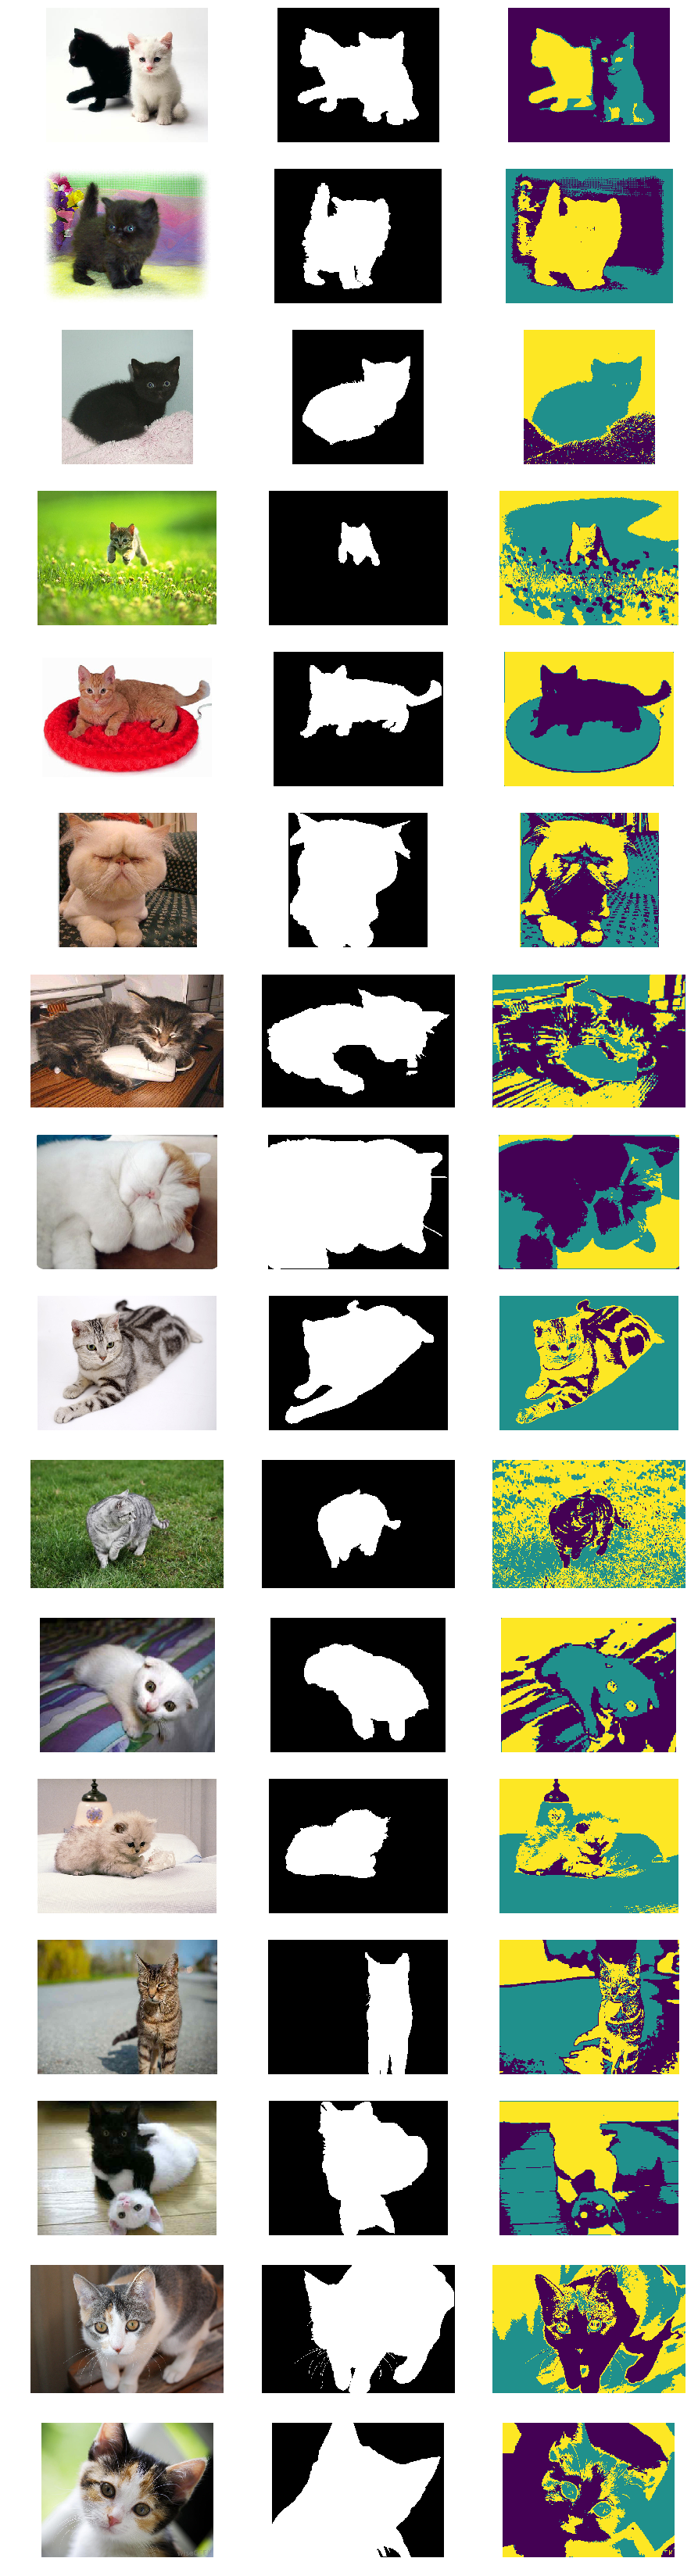

In [36]:
# Visualize segmentation results

N = len(imgs)
plt.figure(figsize=(15,60))
for i in range(N):

    plt.subplot(N, 3, (i * 3) + 1)
    plt.imshow(imgs[i])
    plt.axis('off')

    plt.subplot(N, 3, (i * 3) + 2)
    plt.imshow(gt_masks[i])
    plt.axis('off')

    plt.subplot(N, 3, (i * 3) + 3)
    plt.imshow(segmentations[i], cmap='viridis')
    plt.axis('off')

plt.show()

Include a detailed evaluation of the effect of varying segmentation parameters (feature transform, clustering method, number of clusters, resize) on the mean accuracy of foreground-background segmentations on the provided dataset. You should test a minimum of 10 combinations of parameters. To present your results, add rows to the table below (you may delete the first row).

 <table style="width:100%">
  <tr>
    <th>Feature Transform</th>
    <th>Clustering Method</th>
    <th>Number of segments</th>
    <th>Scale</th>
    <th>Mean Accuracy</th>
  </tr>
  <tr>
    <td>Color</td>
    <td>K-Means</td>
    <td>3</td>
    <td>0.5</td>
    <td>0.58</td>
  </tr>
   <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
</table> 

Observe your results carefully and try to answer the following question:
1. Based on your quantitative experiments, how do each of the segmentation parameters affect the quality of the final foreground-background segmentation?
2. Are some images simply more difficult to segment correctly than others? If so, what are the qualities of these images that cause the segmentation algorithms to perform poorly?
3. Also feel free to point out or discuss any other interesting observations that you made.

Write your analysis in the cell below.

**Your answer here**: